In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=0, transform=None):
        self.transform = transform
        self.train = train

        if self.train == 0:
            self.pathX = path + "train/"
        elif self.train == 1:
            self.pathX = path + "test/"
        else:
            self.pathX = path + "val/"

        self.pathY = "/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/image_data.csv"

        self.img_data = pd.read_csv('/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/image_data.csv')
        self.train_idx = self.img_data.index[self.img_data['folder'] == 'train'].tolist()
        self.test_idx = self.img_data.index[self.img_data['folder'] == 'test'].tolist()
        self.val_idx = self.img_data.index[self.img_data['folder'] == 'val'].tolist()
        
    def __getitem__(self, idx):
        # f = self.data[idx]

        #X
        if self.train == 0:
            i = self.train_idx[idx]
        elif self.train == 1:
            i = self.test_idx[idx]
        else:
            i = self.val_idx[idx]

        img = cv2.imread(self.pathX + str(i) + ".jpg")

        if self.transform is not None:
            img = self.transform(img)

        #Y
        Y = self.img_data['label'][i]

        return (img,i), Y

    def __len__(self):
        if self.train == 0:
            l = len(self.train_idx)
        elif self.train == 1:
            l = len(self.test_idx)
        else:
            l = len(self.val_idx)
        return l

In [18]:
# train_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/", train=0, transform = transforms.Compose([transforms.ToTensor(),
#                                                                                                         transforms.Normalize((0.1307,), (0.3081,))
#                                                                                                        ]))
# train_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/high_pass_filter/", train=0, transform = transforms.Compose([transforms.ToTensor(),
#                                                                                                         transforms.Normalize((0.1307,), (0.3081,))
#                                                                                                        ]))
train_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/to_hsv/", train=0, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                                                                       ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/", train=1, transform = transforms.Compose([transforms.ToTensor(),
#                                                                                                         transforms.Normalize((0.1307,), (0.3081,))
#                                                                                                        ]))
test_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/to_hsv/", train=1, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                                                                       ]))
# test_dataset = LazyLoadDataset("/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/high_pass_filter/", train=1, transform = transforms.Compose([transforms.ToTensor(),
#                                                                                                         transforms.Normalize((0.1307,), (0.3081,))
#                                                                                                        ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

fake tensor(5864)
real tensor(1351)


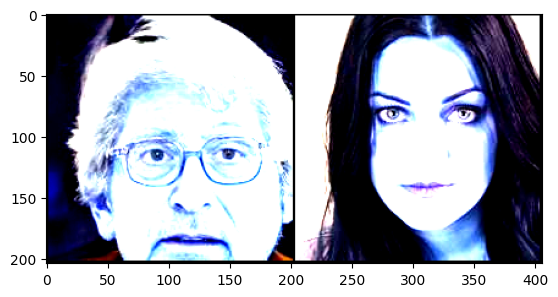

In [ ]:
#visualize one image from each class
import torchvision

img = []
visited_labels = set()
train_loader_iter = iter(train_loader)

while len(visited_labels) < 2:
    (features, idx), labels = next(train_loader_iter)
    for i, label in enumerate(labels):
        if label not in visited_labels:
            visited_labels.add(label)
            img.append(features[i])
            print(label, idx[i])
            
img = torchvision.utils.make_grid(img)
plt.imshow(img.permute(1, 2, 0))

tensor(2405)
tensor(9901)


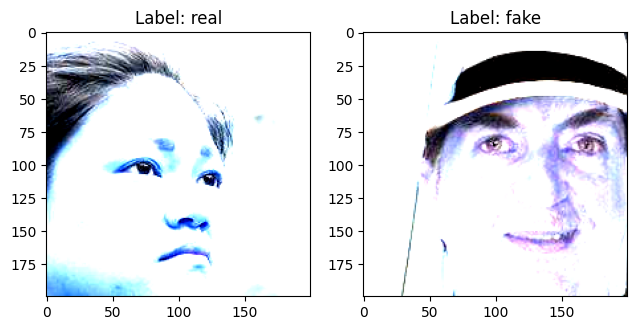

In [ ]:
#or alternatively
import torchvision

fig, axes = plt.subplots(1, 2, figsize=(1.5*5,2*2))

visited_labels = set()
train_loader_iter = iter(train_loader)

while len(visited_labels) < 2:
    (features,idx), labels = next(train_loader_iter)
    for i, label in enumerate(labels):
        if label not in visited_labels:
            ax = axes[len(visited_labels)]
            visited_labels.add(label)
            ax.imshow(features[i].permute(1, 2, 0), cmap='gray')
            ax.set_title('Label: {}'.format(label))
            print(idx[i])
plt.show()           

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
""" 
Creates an Xception Model as defined in:

Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf

This weights ported from the Keras implementation. Achieves the following performance on the validation set:

Loss:0.9173 Prec@1:78.892 Prec@5:94.292

REMEMBER to set your image size to 3x299x299 for both test and validation

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init
import torch

__all__ = ['xception']

model_urls = {
#     'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
    'xception':'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=False,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model

In [19]:
model = xception(pretrained=False,num_classes=2)

In [20]:
import torch.optim as optim
import torchvision.models as models

model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 50

train_losses = []
train_accs = []

test_losses = []
test_accs  = []

test_predictions = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    batch_corr = 0
    
    for batch_idx, ((X_train, idx), y_train) in enumerate(train_loader):

        y_train = list(y_train)

        for j in range(len(y_train)):
            if y_train[j] == 'real':
                y_train[j] = 0
            else:
                y_train[j] = 1

        y_train = torch.tensor(np.asarray(y_train))

        X_train, y_train = X_train.to(device), y_train.to(device)

        # y_pred = model(X_train.view(100, -1))
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
           
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            
            # if batch_idx == 0:
            #     batch_accuracy = 0
            # else:
            #     #batch accuracy
            #     batch_accuracy = trn_corr.item()*100 / (batch_idx * len(X_train))
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    accuracy = trn_corr.item()*100 / (len(train_dataset))

    train_losses.append(loss)
    train_accs.append(accuracy)

    with torch.no_grad():
      
        for (X_test,idx), y_test in test_loader:
          
            y_test = list(y_test)

            for j in range(len(y_test)):
                if y_test[j] == 'real':
                    y_test[j] = 0
                else:
                    y_test[j] = 1

            y_test = torch.tensor(np.asarray(y_test))

            X_test, y_test = X_test.to(device), y_test.to(device)
            
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            if i == epochs - 1:
                test_predictions.extend(predicted.cpu().numpy())

    test_accuracy = tst_corr.item()*100 / (len(test_dataset))

    val_loss = criterion(y_val,y_test)
    test_losses.append(val_loss)
    test_accs.append(test_accuracy)
    print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy} val loss:{val_loss.item()} val accuracy:{test_accuracy}')
    # print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy}')

Train Epoch: 0 [0/2400 (0%)]	Loss: 0.693789
Train Epoch: 0 [640/2400 (26%)]	Loss: 0.681299
Train Epoch: 0 [1280/2400 (53%)]	Loss: 0.725974
Train Epoch: 0 [1920/2400 (79%)]	Loss: 0.661002
epoch: 0 training loss:0.6567578315734863 training accuracy:61.708333333333336 val loss:0.6947765946388245 val accuracy:54.44444444444444
Train Epoch: 1 [0/2400 (0%)]	Loss: 0.558094
Train Epoch: 1 [640/2400 (26%)]	Loss: 0.632814
Train Epoch: 1 [1280/2400 (53%)]	Loss: 0.601318
Train Epoch: 1 [1920/2400 (79%)]	Loss: 0.583409
epoch: 1 training loss:0.5730218887329102 training accuracy:67.66666666666667 val loss:0.8170868158340454 val accuracy:51.666666666666664
Train Epoch: 2 [0/2400 (0%)]	Loss: 0.654298
Train Epoch: 2 [640/2400 (26%)]	Loss: 0.672695
Train Epoch: 2 [1280/2400 (53%)]	Loss: 0.708740
Train Epoch: 2 [1920/2400 (79%)]	Loss: 0.559429
epoch: 2 training loss:0.6734181046485901 training accuracy:65.58333333333333 val loss:0.7533073425292969 val accuracy:51.25
Train Epoch: 3 [0/2400 (0%)]	Loss: 0.6

In [10]:
# test_losses = []
# test_accs  = []

# tst_corr = 0

# model.eval()

# with torch.no_grad():
      
#     for (X_test,idx), y_test in test_loader:

#         y_test = list(y_test)

#         for j in range(len(y_test)):
#             if y_test[j] == 'real':
#                 y_test[j] = 0
#             else:
#                 y_test[j] = 1

#         y_test = torch.tensor(np.asarray(y_test))

#         X_test, y_test = X_test.to(device), y_test.to(device)
        
#         y_val = model(X_test)

#         predicted = torch.max(y_val.data, 1)[1]
#         tst_corr += (predicted == y_test).sum()

#         test_predictions.extend(predicted.cpu().numpy())

# test_accuracy = tst_corr.item()*100 / (len(test_dataset))

# val_loss = criterion(y_val,y_test)
# test_losses.append(val_loss)
# test_accs.append(test_accuracy)
# print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy} val loss:{val_loss.item()} val accuracy:{test_accuracy}')

In [11]:
#save to new csv

test_predictions_df = pd.DataFrame(test_predictions, columns=['original_data'])

test_predictions_df.to_csv('/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/xception.csv', index=False)

In [22]:
# to existing csv

existing_df = pd.read_csv('/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/xception.csv')

assert len(test_predictions) == len(existing_df), "The number of predictions and the number of rows in the existing DataFrame must match."

#name to be changed
existing_df['to_hsv'] = test_predictions

existing_df.to_csv('/content/drive/MyDrive/2023_Spring/Advanced_Topics_in_DS/Project/small_processed_data/xception.csv', index=False)